In [18]:
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input, Reshape, GRU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import pandas as pd
import librosa.display
import soundfile as sf
from tensorflow.keras.models import load_model   #jupyter  notebook
from google.colab import drive

drive.mount('/content/drive')
%cd drive/MyDrive/Colab\ Notebooks

sr = 44100

# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 10 #잘 모르겠음...ㅎㅎ

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 줍니다.
# Vanilla Gan과 DCGAN에서 이렇게 셋팅을 해주는데
# 이렇게 해줘야 훨씬 학습을 잘합니다.
# 그렇다고 합니다..ㅎㅎ
adam = Adam(lr=0.0002, beta_1=0.5)
mfcc_data = []

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks'
/content/drive/MyDrive/Colab Notebooks


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
def load_wave_generator(path): #이전 깃헙에서 가져온 파일 읽어들이는 함수(라벨 붙이는것만 삭제)

    batch_waves = []
    X_data = []
    temp = []
    global mfcc_data

    folders = os.listdir(path)

    for folder in folders:
        if not os.path.isdir(path):continue #폴더가 아니면 continue
        files = os.listdir(path+"/"+folder)
        print("Foldername :",folder,"-",len(files),"files")
        #폴더 이름과 그 폴더에 속하는 파일 갯수 출력
        for wav in files:
            if not wav.endswith(".wav"):continue
            else:
                print("Filename :",wav)#.wav 파일이 아니면 continue
                y, sr = librosa.load(path+"/"+folder+"/"+wav)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=45, hop_length=int(sr*0.01),n_fft=int(sr*0.02)).T

                X_data.extend(mfcc)
                #print("MFCC Size : ", len(mfcc))
    #end loop
    print("X_data :",np.shape(X_data))
    mfcc_data = X_data
    

load_wave_generator("./data")    #일단 RYU 음성 읽어오기
print(np.shape(mfcc_data))

Foldername : 1 - 20 files
Filename : Ryu17.wav
Filename : Ryu20.wav
Filename : Ryu18.wav
Filename : Ryu3.wav
Filename : Ryu13.wav
Filename : Ryu4.wav
Filename : Ryu8.wav
Filename : Ryu1.wav
Filename : Ryu5.wav
Filename : Ryu9.wav
Filename : Ryu2.wav
Filename : Ryu6.wav
Filename : Ryu11.wav
Filename : Ryu10.wav
Filename : Ryu12.wav
Filename : Ryu14.wav
Filename : Ryu19.wav
Filename : Ryu7.wav
Filename : Ryu15.wav
Filename : Ryu16.wav
X_data : (15505, 45)
(15505, 45)


In [20]:
def make_data(data):
    a = []
    data = np.random.permutation(data)
    
    for j, row in enumerate(data):
        if(j+500 == len(data)):
            a = np.array(a)
            return a
        a.append(data[j:j+500])

X_train = make_data(mfcc_data)
X_train.shape

(15005, 500, 45)

In [21]:
generator = Sequential([                 #generator 모델 생성  
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(22500, activation='tanh'),
    Reshape((500,45), input_shape=(22500,)),
])

In [22]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               2816      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 22500)            

In [23]:
discriminator = Sequential()
discriminator.add(GRU(128, input_shape=(500,45)))
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(32, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [24]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128)               67200     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 77,569
Trainable params: 77,569
Non-trainable params: 0
_________________________________________________________________


In [25]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [26]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)
gan = Model(gan_input, output)

In [27]:
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 500, 45)           23722212  
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 77569     
Total params: 23,799,781
Trainable params: 23,722,212
Non-trainable params: 77,569
_________________________________________________________________


In [28]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [29]:
model = load_model('gru_4-26(100%).h5', compile = False)

def test_voice(X_s, model):
    test = X_s

    y_pred = np.argmax(model.predict(test), axis=-1)
    return who(y_pred)

def who(y_pred):
  aaa = 0
  bbb = 0
  ccc = 0
  for i in range(0, len(y_pred)):
    if(y_pred[i] == 0):
      aaa = aaa + 1
    elif(y_pred[i] == 1):
      bbb = bbb + 1
    else:
      ccc = ccc + 1

  result = [aaa,bbb,ccc]
  return result.index(max(result)), result

def model_predict_return(X_s, model):
  # files = os.listdir(path)
    result_index, result = test_voice(X_s, model)

    if result_index == 0:
      return "최창준 목소리 입니다"
    elif result_index == 1:
      return "유일권 목소리 입니다"
    else:
      return "경재원 목소리 입니다"

def chk_predict(generated, epoch):
    gen_mfcc = []
    for i in range(len(generated)):
        for j in range(5):
            gen_mfcc.append(generated[i][j*100:j*100+100])

    gen_mfcc = np.array(gen_mfcc)
    print("Epoch : ",epoch," ", model_predict_return(gen_mfcc, model))

In [30]:
def visualize_training(epoch, d_losses, g_losses, generated):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #test = librosa.feature.inverse.mfcc_to_audio(generated[31].T)
    #librosa.display.waveplot(test, sr=sr, color='r')

In [31]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(len(data) // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

In [32]:
BATCH_SIZE = 32
EPOCHS = 50

Epoch :  1   유일권 목소리 입니다
Epoch :  2   유일권 목소리 입니다
Epoch :  3   유일권 목소리 입니다
Epoch :  4   유일권 목소리 입니다
Epoch :  5   유일권 목소리 입니다
Epoch :  6   최창준 목소리 입니다
Epoch :  7   최창준 목소리 입니다
Epoch :  8   최창준 목소리 입니다
Epoch :  9   최창준 목소리 입니다
Epoch :  10   최창준 목소리 입니다
Epoch :  11   최창준 목소리 입니다
Epoch :  12   최창준 목소리 입니다
Epoch :  13   최창준 목소리 입니다
Epoch :  14   최창준 목소리 입니다
Epoch :  15   최창준 목소리 입니다
Epoch :  16   최창준 목소리 입니다
Epoch :  17   최창준 목소리 입니다
Epoch :  18   최창준 목소리 입니다
Epoch :  19   최창준 목소리 입니다
Epoch :  20   최창준 목소리 입니다
Epoch :  21   최창준 목소리 입니다
Epoch :  22   최창준 목소리 입니다
Epoch :  23   최창준 목소리 입니다
Epoch :  24   최창준 목소리 입니다
Epoch :  25   유일권 목소리 입니다
Epoch :  26   유일권 목소리 입니다
Epoch :  27   유일권 목소리 입니다
Epoch :  28   유일권 목소리 입니다
Epoch :  29   유일권 목소리 입니다
Epoch :  30   유일권 목소리 입니다
Epoch :  31   유일권 목소리 입니다
Epoch :  32   유일권 목소리 입니다
Epoch :  33   유일권 목소리 입니다
Epoch :  34   유일권 목소리 입니다
Epoch :  35   유일권 목소리 입니다
Epoch :  36   유일권 목소리 입니다
Epoch :  37   유일권 목소리 입니다
Epoch :  38   유일권 목소리 입니다
Epoch :  39   유일권 목소리

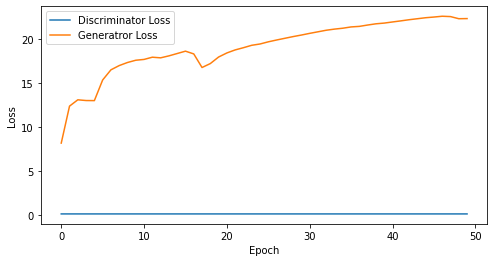

epoch: 50, Discriminator Loss: 0.16255133241415023, Generator Loss: 19.082341175079346


In [33]:
d_losses = []   # discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
g_losses = []
gen_rst = []

for epoch in range(1, EPOCHS + 1):
    for real_sounds in get_batches(X_train, BATCH_SIZE):
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])    # 랜덤 노이즈 생성
        
        generated_sounds = generator.predict(input_noise)                       # 가짜 데이터 생성

        x_dis = np.concatenate([real_sounds, generated_sounds])                 # Gan에 학습할 X 데이터 정의
        
        y_dis = np.zeros(2 * BATCH_SIZE)                                        # Gan에 학습할 Y 데이터 정의
        y_dis[:BATCH_SIZE] = 0.9
        
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)                     # Discriminator 훈련
        
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])          # Gan 훈련
        y_gan = np.ones(BATCH_SIZE)
        
        discriminator.trainable = False                                         # Discriminator의 판별 학습을 방지합니다
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    chk_predict(generated_sounds, epoch)                                        #가짜 음성데이터에 대한 화자 인식

    if(epoch==EPOCHS):                                                          #학습 종료시 마지막 음성데이터 확인 및 학습 확인
        gen_rst=np.array(generated_sounds)
        visualize_training(epoch, d_losses, g_losses, generated_sounds)

In [ ]:
per = [0,0,0];

def chk_GAN_rst(generated, model, epoch):
    gen_mfcc = []
    for i in range(len(generated)):
        for j in range(5):
            gen_mfcc.append(generated[i][j*100:j*100+100])

    gen_mfcc = np.array(gen_mfcc)

    result_index, result = test_voice(gen_mfcc, model)
    per[result_index] = per[result_index]+1

    if result_index == 0:
      rst =  "최창준 목소리 입니다"
    elif result_index == 1:
      rst =  "유일권 목소리 입니다"
    else:
      rst = "경재원 목소리 입니다"
    print("Epoch : ",epoch," ", rst)

for i in range(1000):
    input_noise = np.random.uniform(-1, 1, size=[1,10])
    generated_sounds = generator.predict(input_noise)
    chk_GAN_rst(generated_sounds, model, i)

per

In [41]:
#discriminator.save('dis_v1.h5')

(500, 45)

In [46]:
for i in range(10):
    input_noise = np.random.uniform(-1, 1, size=[1,10])
    generated_sounds = generator.predict(input_noise)
    print("gen ", i," ",discriminator.predict(generated_sounds)," ",generated_sounds.shape)

gen  0   [[2.0013151e-10]]   (1, 500, 45)
gen  1   [[2.0013151e-10]]   (1, 500, 45)
gen  2   [[2.0013112e-10]]   (1, 500, 45)
gen  3   [[2.0013112e-10]]   (1, 500, 45)
gen  4   [[2.0013151e-10]]   (1, 500, 45)
gen  5   [[2.0013112e-10]]   (1, 500, 45)
gen  6   [[2.0013151e-10]]   (1, 500, 45)
gen  7   [[2.0013187e-10]]   (1, 500, 45)
gen  8   [[2.0013112e-10]]   (1, 500, 45)
gen  9   [[2.0013151e-10]]   (1, 500, 45)


In [48]:
dis_rst = discriminator.predict(X_train)

In [54]:
dis_sum = 0;
for i in range(len(dis_rst)):
    dis_sum = dis_sum + dis_rst[i]

dis_sum[0]/len(dis_rst)

0.9006329921276242